In [1]:
# load libraries
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))
suppressWarnings(suppressPackageStartupMessages(library(arrow)))
suppressWarnings(suppressPackageStartupMessages(library(patchwork)))
# import ggplot theme
source("../../utils/figure_themes.r")

## Distance Analysis

In [2]:
# load in the unormalized data
df_raw_path <- file.path("..","..","data","5.converted_data","output.parquet")
df <- arrow::read_parquet(df_raw_path)
# split the Metadata_Image_FileName into the genotype, and side
df$Metadata_genotype <- sapply(strsplit(df$Metadata_Image_FileName_OP, "_"), function(x) x[2])
df$Metadata_side <- sapply(strsplit(df$Metadata_Image_FileName_OP, "_"), function(x) x[4])
df$Metadata_side <- gsub(".tiff", "", df$Metadata_side)
df <- df %>% select(c("Metadata_genotype", "Metadata_identity", "Metadata_side", "Neighbors_FirstClosestDistance_Adjacent"))
# manually correct the high genotype to be 0 for the Neighbors_FirstClosestDistance_Adjacent feature
df$Neighbors_FirstClosestDistance_Adjacent[df$Metadata_genotype == "high"] <- 0

# units are in pixels so convert to microns
resolution = 1.6585 # pixels per micron
df$Neighbors_FirstClosestDistance_Adjacent <- df$Neighbors_FirstClosestDistance_Adjacent / resolution
df$Metadata_genotype <- gsub("wt", "Wild Type", df$Metadata_genotype)
df$Metadata_genotype <- gsub("unsel", "Mid-Severity", df$Metadata_genotype)
df$Metadata_genotype <- gsub("high", "High-Severity", df$Metadata_genotype)
df$Metadata_genotype <- factor(
    df$Metadata_genotype, 
    levels = c("Wild Type", "Mid-Severity", "High-Severity")
)

head(df)

Metadata_genotype,Metadata_identity,Metadata_side,Neighbors_FirstClosestDistance_Adjacent
<fct>,<chr>,<chr>,<dbl>
High-Severity,both,L,0
High-Severity,both,R,0
High-Severity,both,L,0
High-Severity,both,R,0
High-Severity,both,L,0
High-Severity,both,R,0


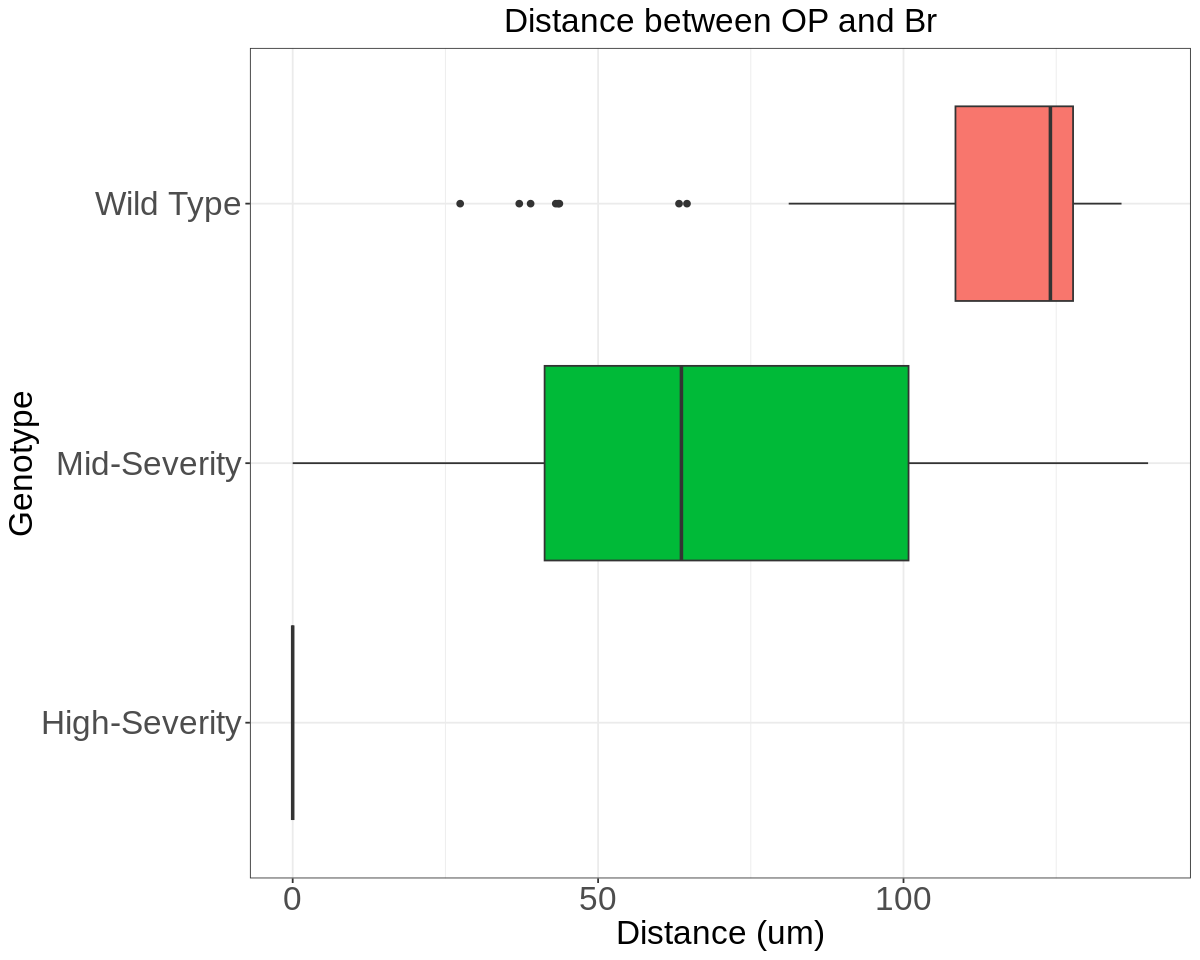

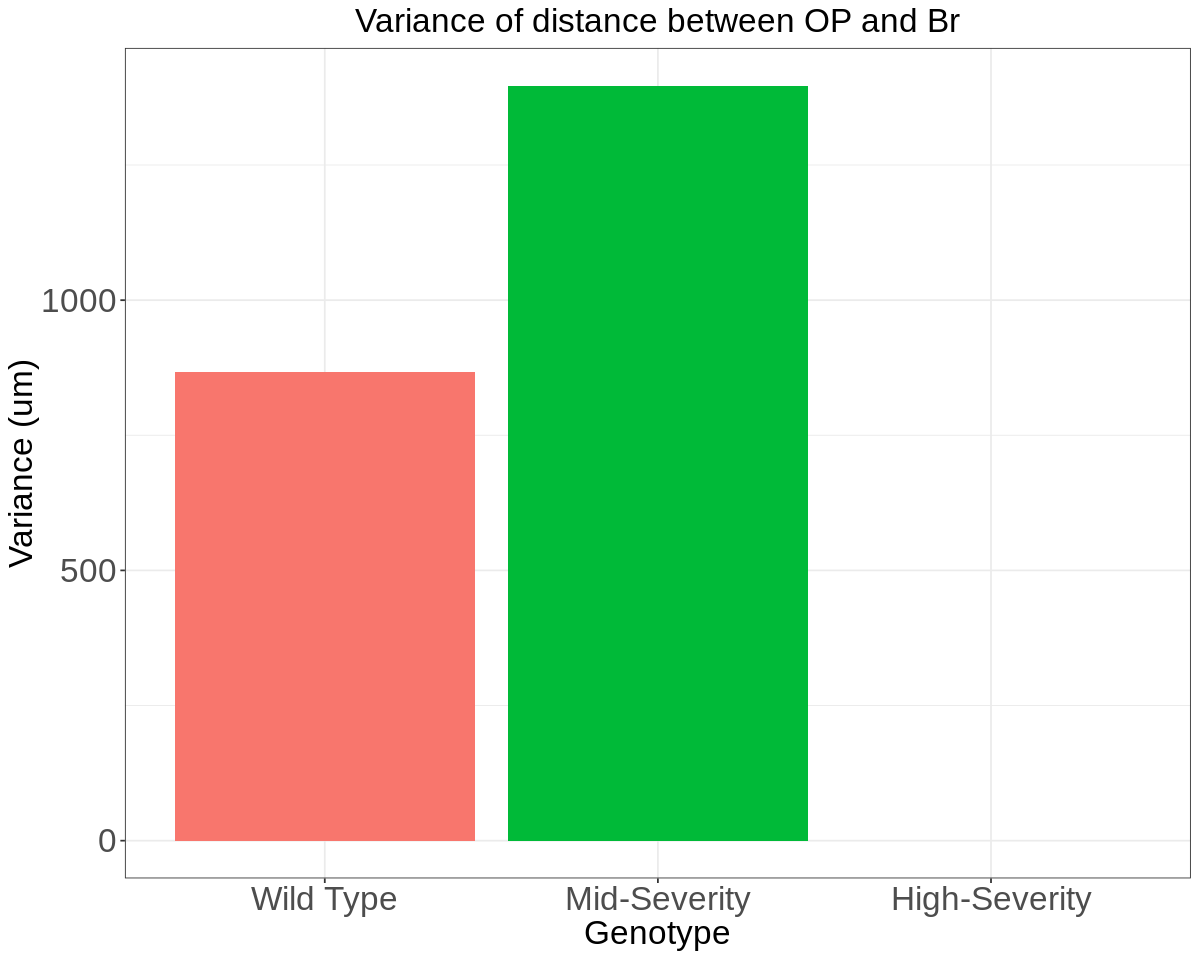

In [3]:
# plot 
width <- 10
height <- 8
options(repr.plot.width = width, repr.plot.height = height)
# reorder the genotype factor
distance_plot <- (
    ggplot(df, aes(
        # reorder the genotype factor
        y = reorder(Metadata_genotype, Neighbors_FirstClosestDistance_Adjacent),
        x = Neighbors_FirstClosestDistance_Adjacent, fill = Metadata_genotype)) 
    + geom_boxplot()
    + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    + labs(title = "Distance between OP and Br", x = "Distance (um)", y = "Genotype", fill = "Genotype")
    + theme_bw()
    + figure_theme
    # drop legend 
    + theme(legend.position = "none")
)
distance_plot
# save the plot
ggsave(file = "distance_plot_genotype.png", plot = distance_plot, path = file.path("..", "figures"), width = width, height = height, dpi = 600)

# reorder the genotype factor
df$Metadata_genotype <- factor(df$Metadata_genotype, levels = c("Wild Type", "Mid-Severity", "High-Severity"))
# plot the variance of the Neighbors_FirstClosestDistance_Adjacent feature
tmp <- df %>% group_by(Metadata_genotype) %>% summarise(mean = mean(Neighbors_FirstClosestDistance_Adjacent), sd = sd(Neighbors_FirstClosestDistance_Adjacent))
tmp$variance <- tmp$sd^2
var_plot <- (
    ggplot(tmp, aes(x = Metadata_genotype, y = variance, fill = Metadata_genotype)) 
    + geom_bar(stat = "identity")
    + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    + labs(title = "Variance of distance between OP and Br", x = "Genotype", y = "Variance (um)", fill = "Genotype")
    + theme_bw()
    + figure_theme
    + theme(legend.position = "none")
)
var_plot
# save the plot
ggsave(file = "distance_variance_plot_genotype.png", plot = var_plot, path = file.path("..", "figures"), width = width, height = height, dpi = 600)